# Code for optimizing catalyst composition using active learning

In [30]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


In [31]:
np.random.seed(404)
np.set_printoptions(precision=2, suppress=True)

In [32]:
# Read data
data = pd.read_excel('Modelling_Data_Phase_1.xlsx', sheet_name ='Seed', index_col=False) #change the sheet name according to the tabs to run the various cycles in the current Phase
data.head()

,Zr,Cu,Co,Fe,STY
0,0.129,0.0,0.000,0.871,236.682003
1,0.135,0.0,0.185,0.680,294.040805
2,0.115,0.0,0.315,0.570,281.273559
3,0.117,0.0,0.460,0.423,243.321402
4,0.125,0.0,0.607,0.268,161.815333


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Zr      31 non-null     float64
 1   Cu      31 non-null     float64
 2   Co      31 non-null     float64
 3   Fe      31 non-null     float64
 4   STY     31 non-null     float64
dtypes: float64(5)
memory usage: 1.3 KB


In [34]:
# General stastistical data
data.describe()

,Zr,Cu,Co,Fe,STY
count,31.000000,31.00000,31.000000,31.000000,31.000000
mean,0.143742,0.24529,0.236065,0.374903,171.513337
std,0.097154,0.26235,0.257175,0.314445,100.103920
min,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.113500,0.00000,0.000000,0.000000,86.619788
50%,0.122000,0.20200,0.177000,0.423000,161.547789
75%,0.142000,0.41300,0.432000,0.658000,249.106089
max,0.438000,0.89100,0.851000,0.871000,324.248728


In [35]:
# Define X and Y from the data. Invert Y by multiplying with -1 to form a MAXIMIZATION problem as BO is MINIMIZATION by default

X = data[['Zr ', 'Cu ', 'Co ', 'Fe']].values
Y = -1*data['STY'].values.reshape(-1, 1) 

In [36]:
#Check the values of X or Y
Y

array([[-236.68],
       [-294.04],
       [-281.27],
       [-243.32],
       [-161.82],
       [ -99.86],
       [  -0.  ],
       [ -86.44],
       [-134.09],
       [-210.05],
       [-299.99],
       [-309.92],
       [  -0.  ],
       [ -90.26],
       [ -86.8 ],
       [ -91.53],
       [ -82.64],
       [ -83.37],
       [-324.25],
       [-218.9 ],
       [ -63.58],
       [-140.57],
       [ -71.58],
       [-161.55],
       [-239.7 ],
       [-238.42],
       [-254.89],
       [-304.16],
       [-321.49],
       [-121.7 ],
       [ -64.04]])

In [37]:
## Import necesarry libraries for Gaussian process regression 

from gpflow.models import GPR
from gpflow.models import SVGP
from gpflow.likelihoods import Gaussian
from gpflow.optimizers import Scipy
from gpflow.kernels import SquaredExponential as SE, Constant as C, White as W, SharedIndependent as SI
from gpflow.inducing_variables import SharedIndependentInducingVariables as SIIV, InducingPoints as IP
from sklearn.metrics import r2_score, mean_squared_error

In [38]:
#Define the kernels using squared exponential. The dimentions of lengthscales must match the number of input features
#This is a single objective task with 4 input features, where each feature correspond to the metal composition

kernel = SE(lengthscales=[0.1,1.3,0.1,0.3])

# Gaussian process regression
gp_model = GPR((X, Y), kernel=kernel)

# Optimize the lengthscales
opt = Scipy()
opt.minimize(gp_model.training_loss, gp_model.trainable_variables)


  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 164.32687378043525
        x: [-1.771e+00 -2.898e-01  7.751e+00 -5.159e-01  1.184e+04
             5.952e+02]
      nit: 68
      jac: [-1.765e+00  2.725e+00  9.630e-03  2.894e+00 -1.889e-04
            -5.006e-04]
     nfev: 83
     njev: 83
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

In [39]:
from sklearn.metrics import r2_score, mean_squared_error

# After optimization, you can make predictions with the trained model
Y_pred_mean, _ = gp_model.predict_y(X)  # Predicted mean values

# Evaluate R^2 score
r2 = r2_score(Y, Y_pred_mean)

# Evaluate mean squared error (RMSE)
mse = mean_squared_error(Y, Y_pred_mean)
rmse = np.sqrt(mse)

# Print the evaluation metrics with limited decimal places
print("R^2 score: {:.2f}".format(r2))
print("Root Mean Squared Error: {:.2f}".format(rmse))

R^2 score: 0.96
Root Mean Squared Error: 18.96


In [40]:
# Optimized kernel parameters

from gpflow.utilities import print_summary
gp_model.kernel.parameters


(<Parameter: name=softplus, dtype=float64, shape=[4], fn="softplus", numpy=array([0.16, 0.56, 7.75, 0.47])>,
 <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=11836.129769808527>)

In [41]:
# Check the optimized hyperparameters

optimized_lengthscales = gp_model.kernel.lengthscales.numpy()
print("Optimized Lengthscales:", optimized_lengthscales)

Optimized Lengthscales: [0.16 0.56 7.75 0.47]


In [ ]:
from sklearn.model_selection import StratifiedKFold

# Create strata based on STY performance levels
#Y_strata = pd.qcut(Y.flatten(), q=3, labels=['bad', 'average', 'good'], duplicates='drop')
Y_strata = pd.Series(
    pd.qcut(Y.flatten(), q=3, labels=['bad', 'average', 'good'], duplicates='drop')
)


# Stratified K-Fold (5 folds)   
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=404)

cv_r2_scores = []
cv_rmse_scores = []
cv_lengthscales = []

print("Stratified Cross-Validation Results:")
print("="*80)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, Y_strata)):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    
    # Show fold composition
    fold_strata = Y_strata.iloc[test_idx].value_counts().sort_index()
    print(f"\nFold {fold+1} test set composition:")
    print(fold_strata)
    
    # Train GP model on this fold
    kernel_fold = SE(lengthscales=[0.1, 1.3, 0.1, 0.3])
    gp_fold = GPR((X_train, Y_train), kernel=kernel_fold)
    opt_fold = Scipy()
    opt_fold.minimize(gp_fold.training_loss, gp_fold.trainable_variables)
    
    # Extract optimized lengthscales for final model
    optimized_ls = gp_fold.kernel.lengthscales.numpy()
    cv_lengthscales.append(optimized_ls)
    
    # Test on held-out fold
    Y_pred, _ = gp_fold.predict_y(X_test)
    r2_fold = r2_score(Y_test, Y_pred)
    rmse_fold = np.sqrt(mean_squared_error(Y_test, Y_pred))
    
    cv_r2_scores.append(r2_fold)
    cv_rmse_scores.append(rmse_fold)
    
    print(f"  Fold R² score: {r2_fold:.4f}")
    print(f"  Fold RMSE: {rmse_fold:.4f}")
    print(f"  Fold lengthscales: {optimized_ls}")

# Report CV validation metrics
print("\n" + "="*80)
print(f"Mean CV R² score: {np.mean(cv_r2_scores):.4f} (+/- {np.std(cv_r2_scores):.4f})")
print(f"Mean CV RMSE: {np.mean(cv_rmse_scores):.4f} (+/- {np.std(cv_rmse_scores):.4f})")

# Create final optimized GP model using averaged CV lengthscales
mean_lengthscales = np.mean(cv_lengthscales, axis=0)
print(f"\nMean CV lengthscales: {mean_lengthscales}")

kernel_optimized = SE(lengthscales=mean_lengthscales)
gp_model = GPR((X, Y), kernel=kernel_optimized)

# Fine-tune on full dataset
opt_final = Scipy()
opt_final.minimize(gp_model.training_loss, gp_model.trainable_variables)

print(f"Final optimized lengthscales (after fine-tuning on full data): {gp_model.kernel.lengthscales.numpy()}")
print("="*80)

Stratified Cross-Validation Results:

Fold 1 test set composition:
bad        3
average    2
good       2
Name: count, dtype: int64
  Fold R² score: 0.5457
  Fold RMSE: 65.3652
  Fold lengthscales: [0.19 0.67 0.63 1.93]

Fold 2 test set composition:
bad        2
average    2
good       2
Name: count, dtype: int64
  Fold R² score: 0.7998
  Fold RMSE: 50.1882
  Fold lengthscales: [  0.15   0.49 300.47   0.51]

Fold 3 test set composition:
bad        2
average    2
good       2
Name: count, dtype: int64
  Fold R² score: 0.2390
  Fold RMSE: 61.8073
  Fold lengthscales: [   0.16 1515.99 1625.83    0.4 ]

Fold 4 test set composition:
bad        2
average    2
good       2
Name: count, dtype: int64
  Fold R² score: 0.8258
  Fold RMSE: 40.6810
  Fold lengthscales: [0.2  0.64 0.46 0.63]

Fold 5 test set composition:
bad        2
average    2
good       2
Name: count, dtype: int64
  Fold R² score: 0.9101
  Fold RMSE: 31.7950
  Fold lengthscales: [0.21 0.53 0.47 0.91]

Mean CV R² score: 0.6641 (+

# Bayesian optimization

In [44]:
from trieste.space import LinearConstraint
from trieste.space import Box

# Define lower and upper bounds for metal fractions
Zr_lb = 0.1
Zr_ub = 0.1
Cu_lb = 0.05
Cu_ub = 0.2
Co_lb = 0.05
Co_ub = 0.5
Fe_lb = 0.4
Fe_ub = 0.8

const_lb = -10
const_ub = 10


# Flo: To reproduce the first suggestions,  adjusts according to supplementary table 2:
Zr_lb = 0.0
Zr_ub = 0.20
Cu_lb = 0.0
Cu_ub = 1.00
Co_lb = 0.0
Co_ub = 1.00
Fe_lb = 0.0
Fe_ub = 1.00

# Flo: To reproduce the first suggestions,  adjusts according to actually displayed boundaries:
# Zr_lb = 0.10
# Zr_ub = 0.12
# Cu_lb = 0.10
# Cu_ub = 0.50
# Co_lb = 0.10
# Co_ub = 0.50
# Fe_lb = 0.20
# Fe_ub = 0.50


# Define linear constraints. Apply lb and ub to the scalar product of the number vector and the feature vector 

constraints = [LinearConstraint(A=tf.constant
        ([[1, 1, 1, 1], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]), 
        lb=tf.constant([1, Zr_lb, Cu_lb, Co_lb, Fe_lb]), 
        ub=tf.constant([1, Zr_ub, Cu_ub, Co_ub, Fe_ub]))]
constrained_search_space = Box([0, 0, 0, 0], [1, 1, 1, 1], constraints=constraints)


In [45]:
# Essential functions for formatting data

from trieste.data import Dataset

def observer(in_):
    in_ = tf.convert_to_tensor(in_)
    out_, _ = gp_model.predict_y(in_)
    out_ = tf.convert_to_tensor(out_)
    return Dataset(in_, out_)

def initial_data(in_, out_):
    in_ = tf.convert_to_tensor(in_)
    out_ = tf.convert_to_tensor(out_)
    return Dataset(in_, out_)

In [46]:
# Import necessary libraries to build model

from trieste.models.gpflow import GaussianProcessRegression
from trieste.bayesian_optimizer import BayesianOptimizer
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.acquisition.function import Fantasizer
from trieste.acquisition import LocalPenalization
from trieste.acquisition.function import ExpectedHypervolumeImprovement
from trieste.acquisition.function import ExpectedImprovement
from trieste.acquisition.function import PredictiveVariance

#Fit the model
model = GaussianProcessRegression(gp_model, num_kernel_samples=10)


# Define acquisition functions. We use the ei rule for exploitation and pv rule for exploration

ei = ExpectedImprovement(constrained_search_space)
rule_ei = EfficientGlobalOptimization(builder=ei)

pv = PredictiveVariance()
rule_pv = EfficientGlobalOptimization(builder=pv)
#Flo tried to add LocalPenalization, but FAILED: rule_pv = LocalPenalization( EfficientGlobalOptimization(builder=pv) )


# Bayesian optimizer
bo = BayesianOptimizer(observer, constrained_search_space)


In [47]:
# Run the Bayesian optimizer for single objective

batch_size = 30 # This number is user defined and determines the number of recommendation made by the BO. Typically 5-10 generations yield good results. For the project, we used a batch of 30. 

# Alternate between rule_ei or rule_pv as parmaters when runnig the BO for exploitation or exploration campaigns, respectively.
bo_result = bo.optimize(batch_size, initial_data(X, Y), model, rule_pv, track_state = False, fit_initial_model=False)

c:\Users\Flo\anaconda3\envs\ramirez\lib\site-packages\scipy\optimize\_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Optimization completed without errors


In [48]:
# Get results from the Bayesian optimizer
bo_initial_data = bo_result.try_get_final_dataset()
bo_X = bo_result.try_get_final_dataset().query_points.numpy()[-batch_size:,:]

bo_Y = -1*bo_result.try_get_final_dataset().observations.numpy()[-batch_size:,:]
np.set_printoptions(precision=3, suppress=True)

result=(np.concatenate((bo_X, bo_Y), axis=1))


In [49]:
# Create dataframe with results 

dfresult = pd.DataFrame(result, columns = ['Zr','Cu','Co','Fe','STY'])
dfresult.round(4).sort_values(by="STY", ascending=True)

,Zr,Cu,Co,Fe,STY
5,0.2,0.4338,0.3662,0.0000,81.6886
2,0.2,0.4890,0.3110,0.0000,82.0225
12,0.2,0.6050,0.1950,0.0000,82.5000
9,0.2,0.0041,0.7959,0.0000,82.5746
17,0.2,0.7398,0.0602,0.0000,82.9887
21,0.2,0.3401,0.4599,0.0000,83.2243
27,0.2,0.6357,0.1643,0.0000,83.4442
24,0.2,0.0002,0.7998,0.0000,83.4637
26,0.2,0.0000,0.5795,0.2205,134.0297
18,0.2,0.0000,0.5723,0.2277,136.8612


In [50]:
#The above dataframe is the output of the current campiagn recommending catalyst composition worth investigation and its predicted yield.
#In the study we performed these experimental recommendation and measured the actual yield

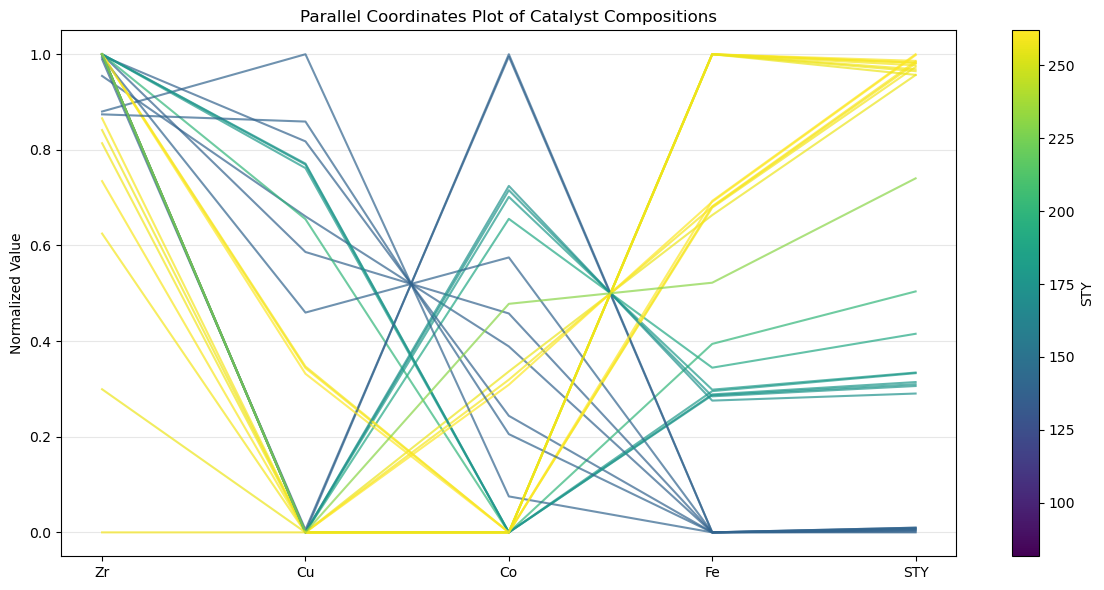

In [51]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

# Prepare data for parallel coordinates plot
df = dfresult
df_normalized = df.copy()
columns = ['Zr', 'Cu', 'Co', 'Fe', 'STY']

# Normalize columns to 0-1 range for plotting
for col in columns:
    min_val = df_normalized[col].min()
    max_val = df_normalized[col].max()
    df_normalized[col] = (df_normalized[col] - min_val) / (max_val - min_val)

# Create parallel coordinates plot
fig, ax = plt.subplots(figsize=(12, 6))

# Color map based on STY values
colors = cm.viridis(df['STY'] / df['STY'].max())

# Plot lines for each sample
x_positions = np.arange(len(columns))
for idx, row in df_normalized.iterrows():
    ax.plot(x_positions, row[columns].values, color=colors[idx], alpha=0.7, linewidth=1.5)

# Customize plot
ax.set_xticks(x_positions)
ax.set_xticklabels(columns)
ax.set_ylabel('Normalized Value')
ax.set_title('Parallel Coordinates Plot of Catalyst Compositions')
ax.set_ylim(-0.05, 1.05)
ax.grid(axis='y', alpha=0.3)

# Add colorbar
sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=df['STY'].min(), vmax=df['STY'].max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='STY')

plt.tight_layout()
plt.show()

In [52]:
df_suggestions_manu = pd.read_excel('Full_catalytic_performance_data_Zenodo.xlsx', 
                                     sheet_name='Phase 1', 
                                     usecols='C:G', 
                                     skiprows=1, 
                                     nrows=6)
# Standardize column names by stripping whitespace
df_suggestions_manu.columns = df_suggestions_manu.columns.str.strip()
df_suggestions_manu.rename(columns={df_suggestions_manu.columns[-1]: 'STY'}, inplace=True)
df_suggestions_manu

,Zr,Cu,Co,Fe,STY
0,0.10,0.49,0.20,0.21,137.53
1,0.10,0.20,0.48,0.22,159.17
2,0.10,0.42,0.10,0.38,198.38
3,0.10,0.20,0.22,0.48,270.86
4,0.12,0.10,0.41,0.37,228.67
5,0.12,0.10,0.15,0.63,317.35


In [53]:
df_suggestions_flo = dfresult

from scipy.spatial.distance import euclidean

closest_matches = {}

for idx_manu, row_manu in df_suggestions_manu.iterrows():
    cols = ['Zr', 'Cu', 'Co', 'Fe']
    manu_values = df_suggestions_manu.loc[idx_manu].values[0:4] # ugly workaround, because row_manu[cols] and even row_manu['Fe'] FAILED for unknown reasons.

    distances = [ euclidean(manu_values, row_flo.values[0:4]) for i_flo, row_flo in df_suggestions_flo.iterrows() ]

    closest_idx = np.argmin(distances)
    closest_matches[idx_manu] = {
        'i_flo': closest_idx,
        'distance': distances[closest_idx],
    }


closest_matches

{0: {'i_flo': 0, 'distance': 0.23689355010830415},
 1: {'i_flo': 4, 'distance': 0.23465233449820921},
 2: {'i_flo': 7, 'distance': 0.16839859235997187},
 3: {'i_flo': 8, 'distance': 0.23451729126829446},
 4: {'i_flo': 28, 'distance': 0.13945149962145248},
 5: {'i_flo': 23, 'distance': 0.17808465718359387}}

In [54]:

sorted_matches = sorted(closest_matches.items(), key=lambda x: x[1]['distance'])

for idx_manu, match_info in sorted_matches:

    distance = match_info['distance']
    
    print(f"Distance: {distance:.4f}")

    print(f"Manu:")
    print(df_suggestions_manu.loc[idx_manu].round(2))
    
    print(f"Flo:")
    print(df_suggestions_flo.loc[ match_info['i_flo'] ].round(2))
    print("-"*100)


Distance: 0.1395
Manu:
Zr       0.12
Cu       0.10
Co       0.41
Fe       0.37
STY    228.67
Name: 4, dtype: float64
Flo:
Zr       0.20
Cu       0.00
Co       0.38
Fe       0.42
STY    215.14
Name: 28, dtype: float64
----------------------------------------------------------------------------------------------------
Distance: 0.1684
Manu:
Zr       0.10
Cu       0.42
Co       0.10
Fe       0.38
STY    198.38
Name: 2, dtype: float64
Flo:
Zr       0.20
Cu       0.48
Co       0.00
Fe       0.32
STY    172.52
Name: 7, dtype: float64
----------------------------------------------------------------------------------------------------
Distance: 0.1781
Manu:
Zr       0.12
Cu       0.10
Co       0.15
Fe       0.63
STY    317.35
Name: 5, dtype: float64
Flo:
Zr       0.20
Cu       0.00
Co       0.25
Fe       0.55
STY    261.60
Name: 23, dtype: float64
----------------------------------------------------------------------------------------------------
Distance: 0.2345
Manu:
Zr       0.10
Cu       0

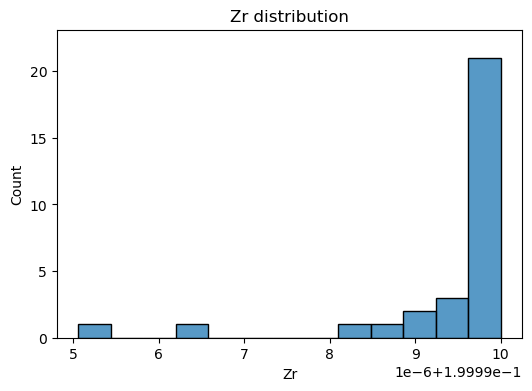

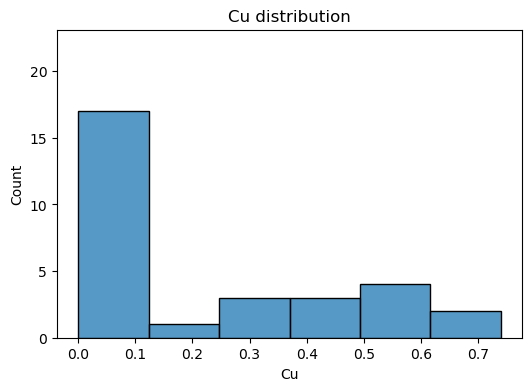

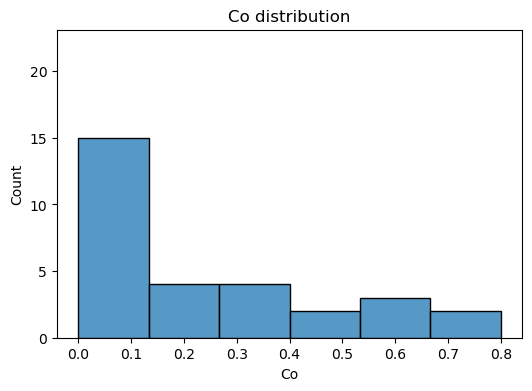

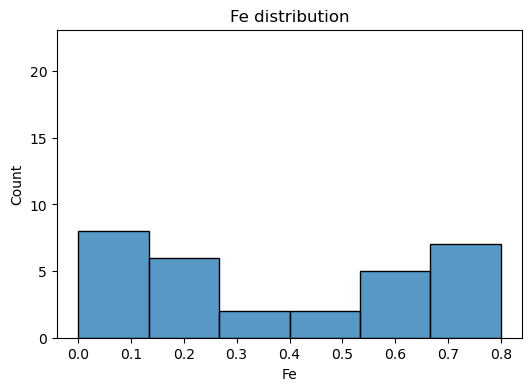

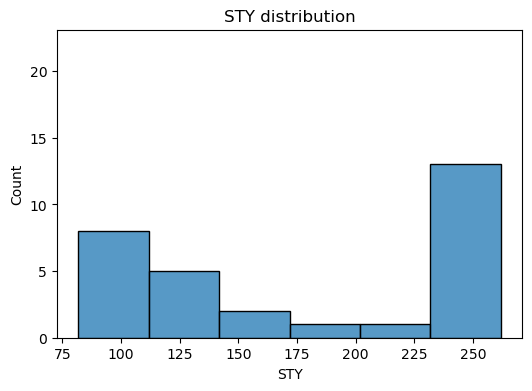

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

df = dfresult

# Find the maximum count across all histograms
max_count = 0
for col in df.select_dtypes(include='number').columns:
    counts, _ = np.histogram(df[col], bins='auto')
    max_count = max(max_count, counts.max())

# Plot with consistent y-axis
for col in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=False)
    plt.title(f"{col} distribution")
    plt.ylim(0, max_count * 1.1)  # Add 10% padding
    plt.show()

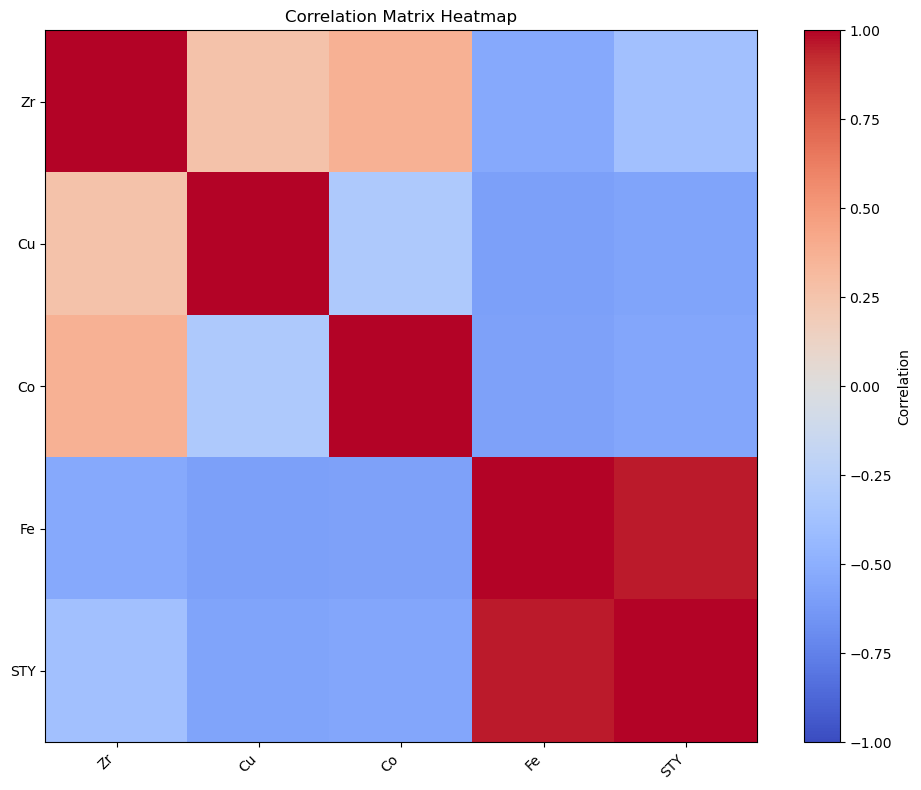

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

corr = df.corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label="Correlation")

plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.columns)), corr.columns)

plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

C:\Users\Flo\AppData\Local\Temp\ipykernel_13604\1828191413.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


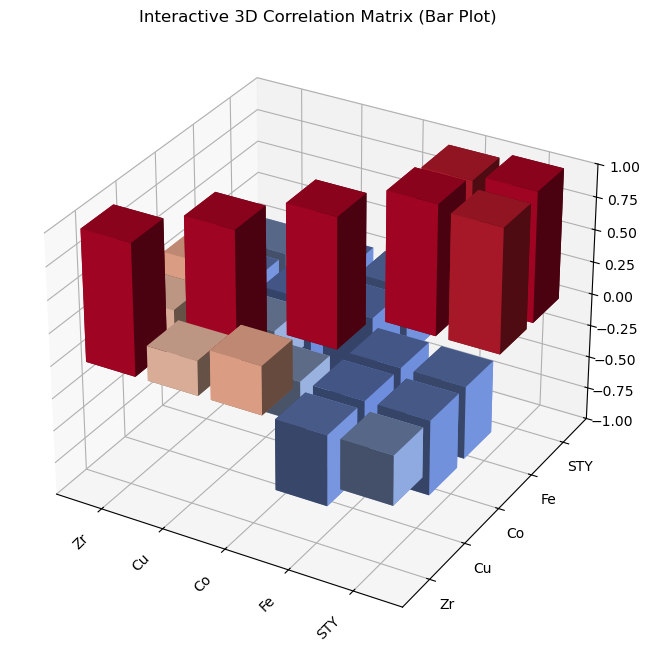

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


# Compute correlation matrix
corr = df.corr()

# Prepare grid
n = corr.shape[0]
xpos, ypos = np.meshgrid(np.arange(n), np.arange(n))
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

# Bar sizes
dx = dy = 0.8
dz = corr.values.flatten()

# Normalize colors for colormap
norm = plt.Normalize(-1, 1)
colors = plt.cm.coolwarm(norm(dz))

# Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors, shade=True)

# Axis labels
ax.set_xticks(np.arange(n) + dx/2)
ax.set_yticks(np.arange(n) + dy/2)
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)

ax.set_zlim(-1, 1)
ax.set_title("Interactive 3D Correlation Matrix (Bar Plot)")

plt.tight_layout()
plt.show()